In [37]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution


In [38]:
date = '20220512'
dataNo = 6
scanNo = 6

In [39]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [40]:
param_name = 'A0157: OL (H1): AM for physics 2'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[4]
sample3 = unique_param[14]
unit = '[V]'

In [41]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No image")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '7.2[V]')

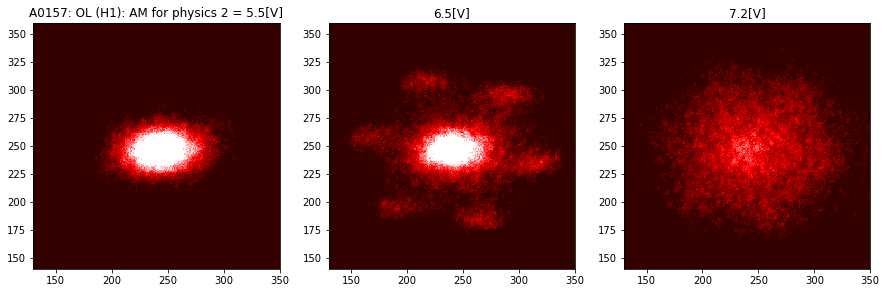

In [42]:
vmin = 100
vmax = 700
xlim_1 = 130
xlim_2 = 350
ylim_1 = 140
ylim_2 = 360

cmap = image.generate_cmap(['#330000', 'r', 'w'])

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [43]:
cx = 240
cy = 245
wx = 12
wy = 8
shift_dx_list = [0, 72, -67, 26, -22, 50, -48, 69, -62, 17, -11, 62, -53]
shift_dy_list = [0, -9, 12, -59, 63, 50, -48, 24, -17, 62, -55, -41, 47]

subROI_parameters_list = []

def createSubROI(mainROI_cx, mainROI_cy, wx, wy, shift_dx=0, shift_dy=0):
    subROI_x0 = mainROI_cx + shift_dx - wx
    subROI_x1 = mainROI_cx + shift_dx + wx
    subROI_y0 = mainROI_cy + shift_dy - wy
    subROI_y1 = mainROI_cy + shift_dy + wy
    subROI_xmesh, subROI_ymesh = np.meshgrid(np.arange(subROI_x0,subROI_x1), np.arange(subROI_y0,subROI_y1))
    return subROI_xmesh, subROI_ymesh, subROI_x0, subROI_x1, subROI_y0, subROI_y1

for i in range(len(shift_dx_list)):
    subROI_parameters_temp = createSubROI(cx,cy, wx, wy, shift_dx_list[i], shift_dy_list[i])
    subROI_parameters_list.append(subROI_parameters_temp)

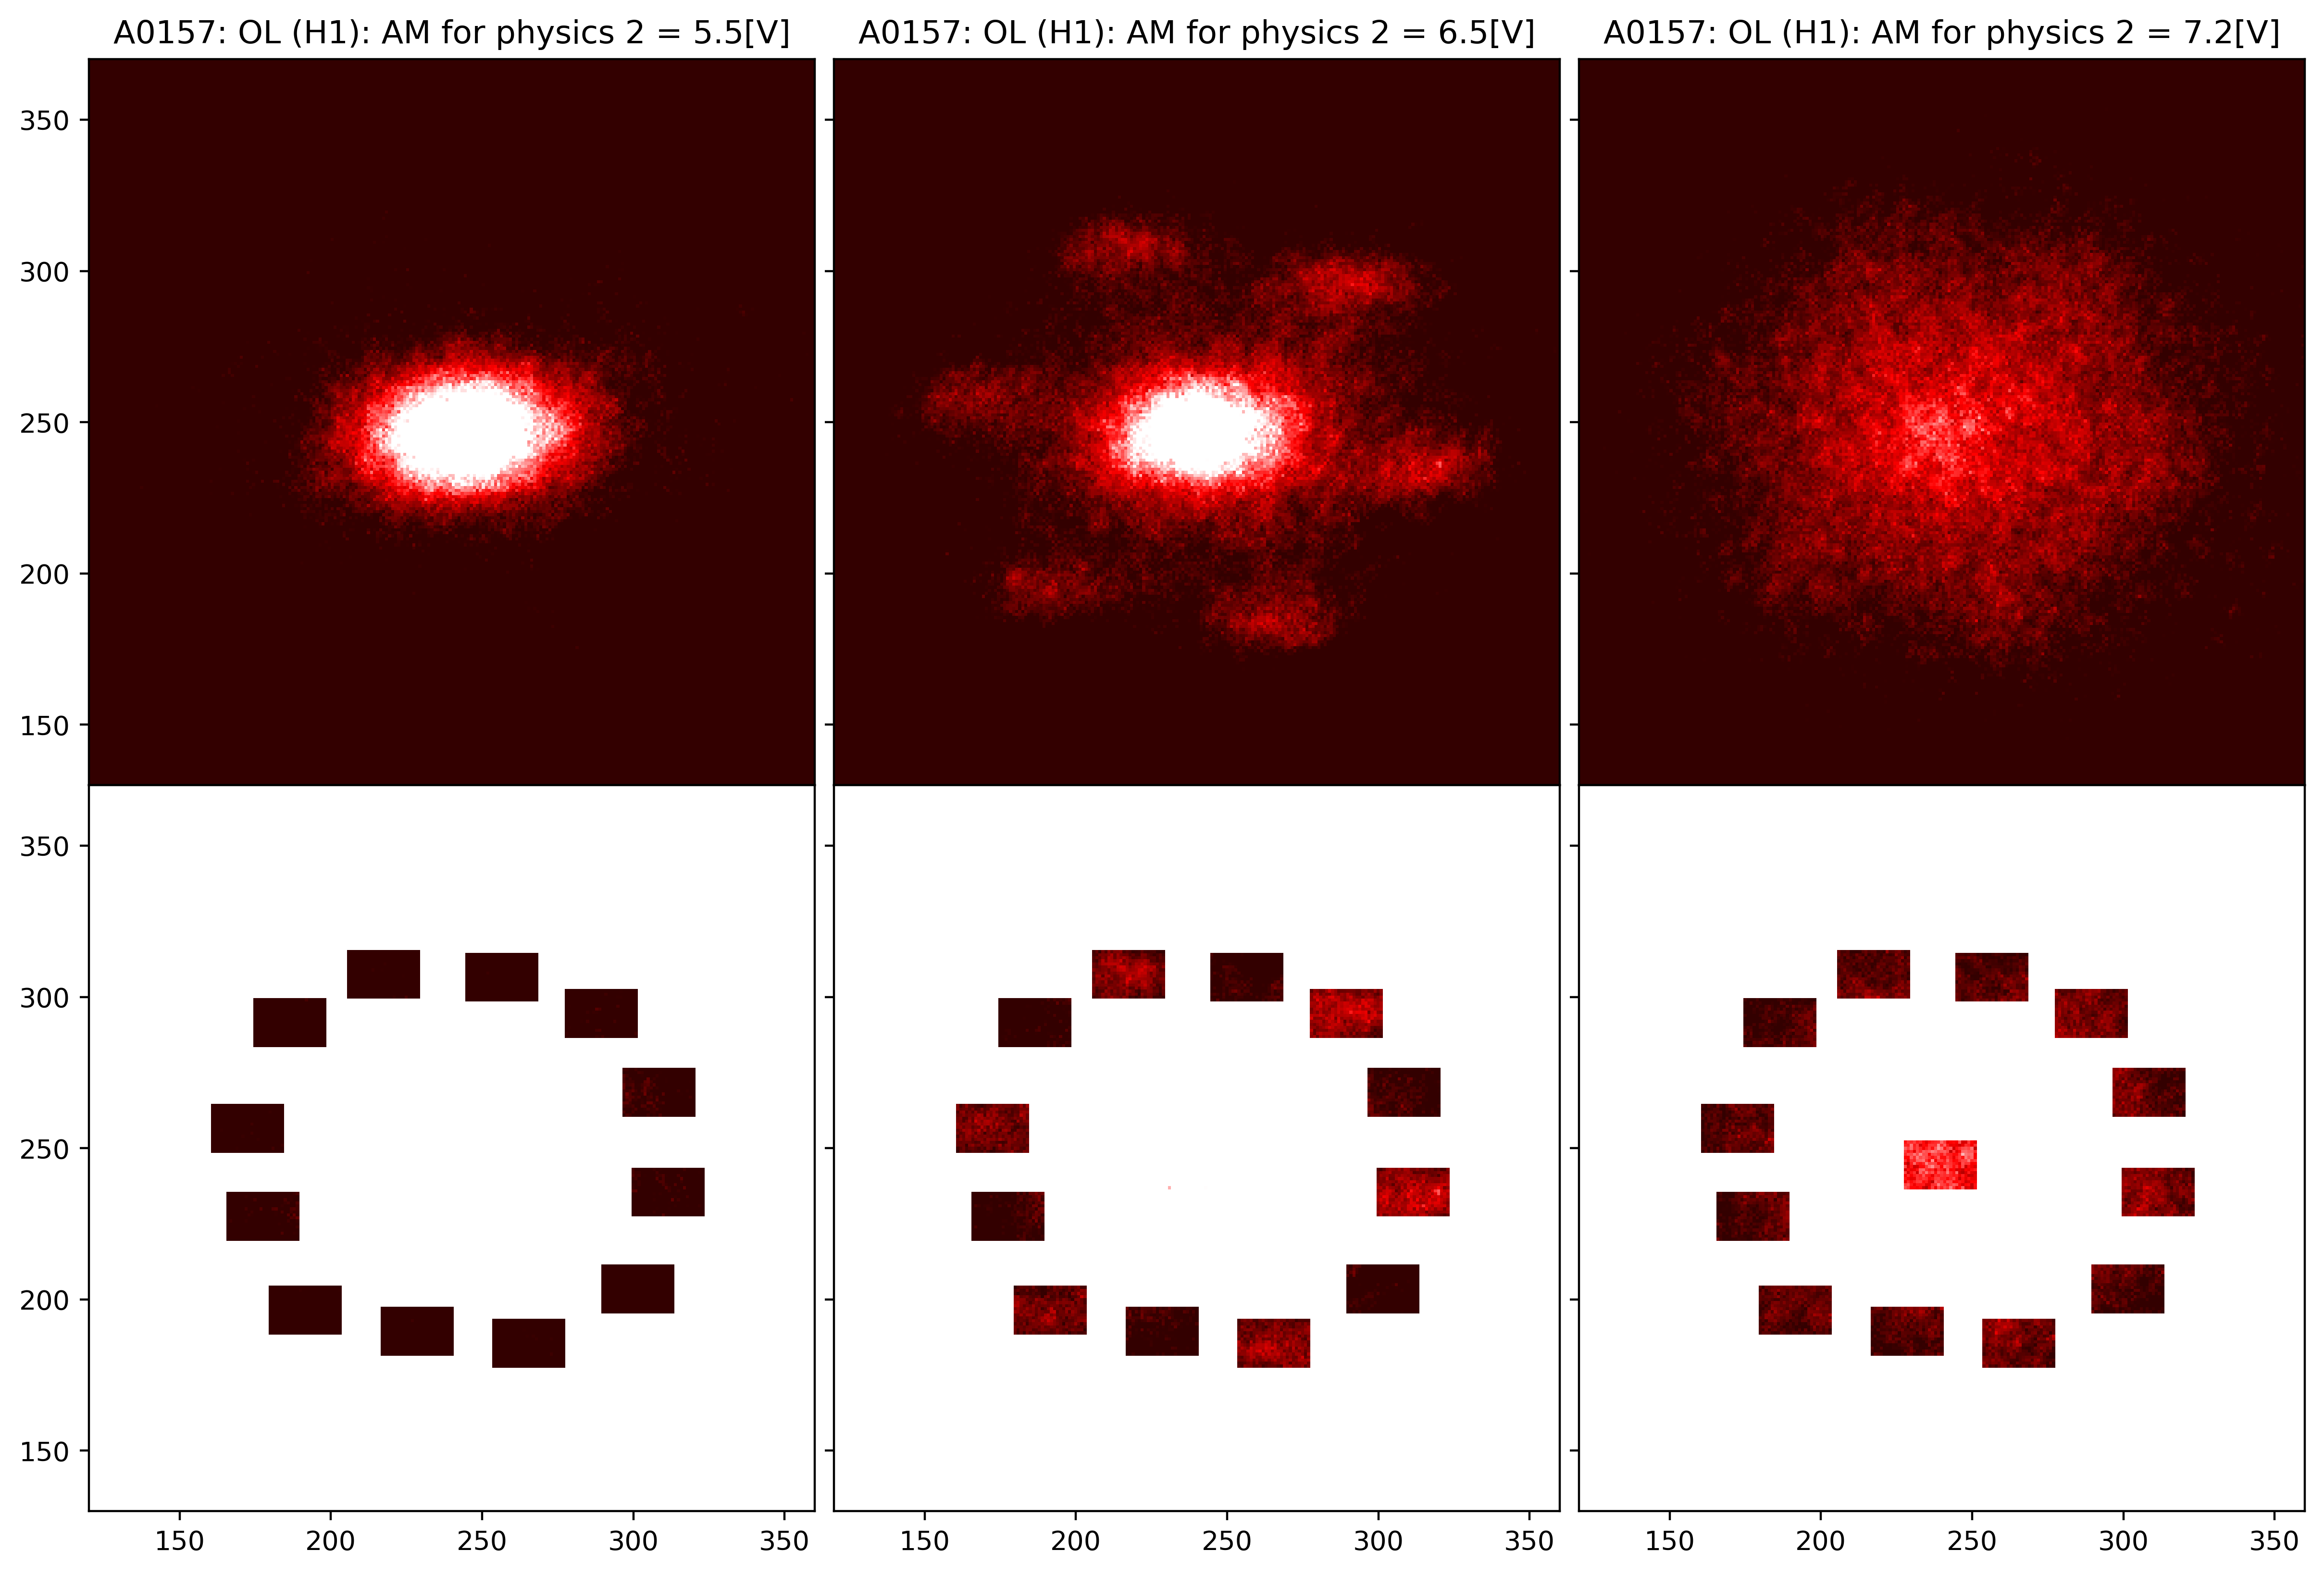

In [44]:
vmin = 100
vmax = 700
xlim_1 = 120
xlim_2 = 360
ylim_1 = 130
ylim_2 = 370

sampleImages_list = [img_trans_sample1, img_trans_sample2, img_trans_sample3]
sample_list = [sample1, sample2, sample3]
fig, axs = plt.subplots(ncols=len(sampleImages_list), nrows=2, figsize=[15, 10], dpi=400, sharex=True, sharey=True)
axs = np.reshape(axs, [-1, ])
for i in range(len(sampleImages_list)*2):
    if i<len(sampleImages_list):
        axs[i].pcolormesh(sampleImages_list[i], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
        axs[i].set_title(param_name+ " = %.01f"%(sample_list[i])+unit)
    else:
        for j in range(len(shift_dx_list)):
            axs[i].pcolormesh(subROI_parameters_list[j][0],subROI_parameters_list[j][1],sampleImages_list[i-len(sampleImages_list)][subROI_parameters_list[j][4]:subROI_parameters_list[j][5],subROI_parameters_list[j][2]:subROI_parameters_list[j][3]], vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(xlim_1,xlim_2)
    axs[i].set_ylim(ylim_1,ylim_2)
fig.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [45]:
center_list = []
side1_list = []
side2_list = []
side3_list = []
diff_list = []
thermal_list = []
center_err_list = []
side1_err_list = []
side2_err_list = []
side3_err_list = []
diff_err_list = []
thermal_err_list = []
visibility_list = []
visibility_err_list = []  
for i in range(len(unique_param)):
    center_temp = []
    side1_temp = []
    side2_temp = []
    side3_temp = []
    diff_temp = []
    thermal_temp = []
    visibility_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            center_temp.append(np.sum(img_trans_list[j][subROI_parameters_list[0][4]:subROI_parameters_list[0][5],subROI_parameters_list[0][2]:subROI_parameters_list[0][3]])/np.sum(img_trans_list[j]))
            side1_temp.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(1,3,1))))/np.sum(img_trans_list[j]))
            side2_temp.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(3,5,1))))/np.sum(img_trans_list[j]))
            side3_temp.append(np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(5,7,1))))/np.sum(img_trans_list[j]))
            coherent = np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(1,7,1))))
            thermal =  np.sum(list(map(lambda x: img_trans_list[j][subROI_parameters_list[x][4]:subROI_parameters_list[x][5],subROI_parameters_list[x][2]:subROI_parameters_list[x][3]], range(7,13,1))))
            diff_temp.append(coherent/np.sum(img_trans_list[j]))
            thermal_temp.append(thermal/np.sum(img_trans_list[j]))
            visibility_temp.append((coherent-thermal)/(coherent+thermal))
    center_list.append(np.mean(center_temp))
    side1_list.append(np.mean(side1_temp))
    side2_list.append(np.mean(side2_temp))
    side3_list.append(np.mean(side3_temp))
    diff_list.append(np.mean(diff_temp))
    thermal_list.append(np.mean(thermal_temp))
    visibility_list.append(np.mean(visibility_temp))
    center_err_list.append(np.std(center_temp))
    side1_err_list.append(np.std(side1_temp))
    side2_err_list.append(np.std(side2_temp))
    side3_err_list.append(np.std(side3_temp))
    diff_err_list.append(np.std(diff_temp))
    thermal_err_list.append(np.std(thermal_temp))
    visibility_err_list.append(np.std(visibility_temp))

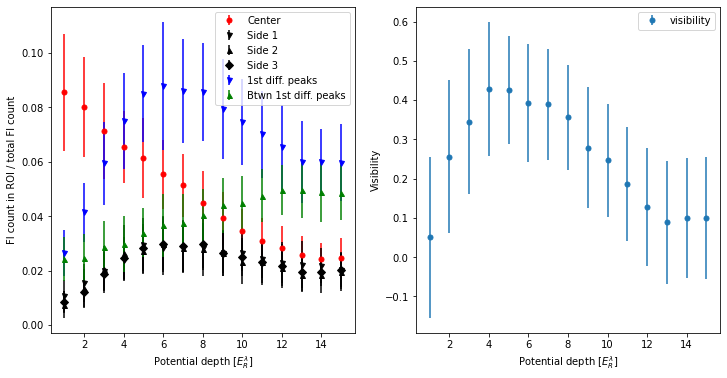

In [46]:
unique_param = range(1,16)
fig =plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(unique_param,center_list,center_err_list,fmt='o',c='r',markersize=5,label='Center')
ax1.errorbar(unique_param,side1_list,side1_err_list, fmt='v',c='black',markersize=5,label='Side 1')
ax1.errorbar(unique_param,side2_list,side2_err_list, fmt='^',c='black',markersize=5,label='Side 2')
ax1.errorbar(unique_param,side3_list,side3_err_list,fmt='D',c='black',markersize=5,label='Side 3')
ax1.errorbar(unique_param,diff_list,diff_err_list, fmt='v',c='b',markersize=5,label='1st diff. peaks')
ax1.errorbar(unique_param,thermal_list,thermal_err_list, fmt='^',c='g',markersize=5,label='Btwn 1st diff. peaks')
# ax1.plot(x_list,p_center(x_list),c='black',label='Poly. fit to Center, x_peak=%.02f [ms]'%(center_max['x']))
# ax1.plot(x_list,p_side1(x_list),c='gray',label='Poly. fit to Side1,x_peak=%.02f [ms]'%(side1_max['x']))
ax1.set_xlabel(r"Potential depth $[E_R^{\lambda}]$")
ax1.set_ylabel('Fl count in ROI / total Fl count')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,visibility_list,visibility_err_list,fmt='o',markersize=5,label='visibility')
ax2.set_ylabel('Visibility')
ax2.set_xlabel(r"Potential depth $[E_R^{\lambda}]$")
ax2.legend()